## packages

In [2]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import os,random
import cv2
os.environ["KERAS_BACKEND"] = "theano"
from keras.utils import np_utils
import keras.models as models
from keras.layers import Input,merge
from keras.layers.core import Reshape,Dense,Dropout,Activation,Flatten,MaxoutDense
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import *
from keras.models import Sequential
from keras.layers.wrappers import TimeDistributed
from keras.layers.noise import GaussianNoise
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, UpSampling2D
from keras.layers.recurrent import LSTM
from keras.regularizers import *
from keras.layers.normalization import *
from keras.optimizers import *
from keras.datasets import mnist
import cPickle, random, sys, keras
from keras.models import Model
from IPython import display
from keras.utils import np_utils
from tqdm import tqdm

# fix random seed for reproducibility
seed = 2000
np.random.seed(seed)

experiment='rv32by32_bs8'

## settings

In [4]:
path2data='./data/'
h, w = 32, 32

## All functions are here.

In [22]:
def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val
        
def get_stats(X):
    print 'array shape:', X.shape
    print 'min: %s  max: %s  mean: %s  std: %s' %(np.min(X),np.max(X),np.mean(X),np.std(X))
    print '-'*50
    
def preprocess(X,Y,params):
    
    h=params['h']
    w=params['w']
    norm_type=params['norm_type']
    
    if Y is None:
        Y=np.zero_like(X)
        
    # downsample    
    X = cv2.resize(X, (w, h), interpolation=cv2.INTER_CUBIC)
    Y = cv2.resize(Y, (w, h), interpolation=cv2.INTER_CUBIC)
    
    # reshape        
    X = np.transpose(X,(2,0,1))
    X=np.expand_dims(X,axis=1)
    Y = np.transpose(Y,(2,0,1))
    Y=np.expand_dims(Y,axis=1)
    

    X = X.astype('float32')
    if norm_type is 'minusplusone':
        # normalized to [-1,1]
        xmaxd2=np.max(X)/2
        X-=xmaxd2
        X/=xmaxd2## load data
    elif norm_type is 'zeromeanunitvar':
        X-=np.mean(X)
        X/=np.std(X)
    else:
        X/=np.max(X)
    return X,Y

def plot_loss(losses):
        display.clear_output(wait=True)
        display.display(plt.gcf())
        plt.figure(figsize=(10,8))
        plt.plot(losses["d"], label='discriminitive loss')
        plt.plot(losses["g"], label='generative loss')
        plt.legend()
        plt.show()
        
    
def plot_gen(n_ex=8,dim=(4,4), figsize=(10,10) ):
    noise = np.random.uniform(0,1,size=[n_ex,100])
    generated_images = generator.predict(noise)

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],2*i+1)
        img = generated_images[i,0,:,:]
        label = generated_images[i,1,:,:]>.5
        plt.imshow(img,cmap='Greys_r')
        plt.axis('off')
        plt.subplot(dim[0],dim[1],2*i+2)
        plt.imshow(label,cmap='Greys_r')
        
    plt.tight_layout()
    plt.show()
    
def train_for_n(nb_epoch=5000, plt_frq=50,BATCH_SIZE=32):

    for e in tqdm(range(nb_epoch)):  
        
        # Make generative images
        image_batch = X_train[np.random.randint(0,X_train.shape[0],size=BATCH_SIZE),:,:,:]    
        noise_gen = np.random.uniform(-1,1,size=[BATCH_SIZE,100])
        generated_images = generator.predict(noise_gen)
        
        # Train discriminator on generated images
        X = np.concatenate((image_batch, generated_images))
        y = np.zeros([2*BATCH_SIZE,1])
        y[0:BATCH_SIZE,0] = 1
        #y[BATCH_SIZE:,0] = 1
        
        #make_trainable(discriminator,True)
        d_loss  = discriminator.train_on_batch(X,y)
        losses["d"].append(d_loss)
    
        # train Generator-Discriminator stack on input noise to non-generated output class
        noise_tr = np.random.uniform(-1,1,size=[BATCH_SIZE,100])
        y2 = np.zeros([BATCH_SIZE,1])
        y2[:,0] = 1
        
        #make_trainable(discriminator,False)
        g_loss = GAN.train_on_batch(noise_tr, y2 )
        losses["g"].append(g_loss)
        
        # Updates plots
        if e%plt_frq==plt_frq-1:
            plot_loss(losses)
            plot_gen()
            
def pick_large_contours(X,Y,threshold):
    k1=0
    for k in range(Y.shape[2]):
        area=np.count_nonzero(Y[:,:,k])
        if area>threshold:
            if k1==0:
                Xs=X[:,:,k]
                Ys=Y[:,:,k]
                Xs=np.expand_dims(Xs,axis=2)
                Ys=np.expand_dims(Ys,axis=2)
            else:
                x1=X[:,:,k]
                x1=np.expand_dims(x1,axis=2)                
                Xs=np.append(Xs,x1,axis=2)
                y1=Y[:,:,k]
                y1=np.expand_dims(y1,axis=2)
                Ys=np.append(Ys,y1,axis=2)
            k1=k1+1
    #print 'Xs:'  %Xs.shape      
    #print 'Ys:'  %Ys.shape      
    #print '-' *50
    return Xs,Ys
        
def initNormal(shape, name=None):
	return initializations.normal(shape, scale=0.02, name=name)    

def grays_to_RGB(img):
    # turn 2D grayscale image into grayscale RGB
    return np.dstack((img, img, img))


def image_with_mask(img, mask,color=(0,255,0)):
    #img=np.asarray(img,dtype='uint8')
    mask=np.asarray(mask,dtype='uint8') 
    if np.max(mask)==1:
        mask=mask*255

    # returns a copy of the image with edges of the mask added in red
    if len(img.shape)==2:	
        img_color = grays_to_RGB(img)
    else:
        img_color =img

    mask_edges = cv2.Canny(mask, 100, 200) > 0
    img_color[mask_edges, 0] = color[0]  # set channel 0 to bright red, green & blue channels to 0
    img_color[mask_edges, 1] = color[1]
    img_color[mask_edges, 2] = color[2]
    img_color=img_color#/float(np.max(img))
    plt.axis('off')
    return img_color


def plot_real(n_ex=8,dim=(4,4), figsize=(10,10) ):
    
    idx = np.random.randint(0,X_train.shape[0],n_ex)
    generated_images = X_train[idx,:,:,:]

    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0],dim[1],2*i+1)
        img = generated_images[i,0,:,:]
        plt.imshow(img,cmap='Greys_r')

        plt.subplot(dim[0],dim[1],2*i+2)
        label = generated_images[i,1,:,:]
        plt.imshow(label,cmap='Greys_r')
        
        plt.axis('off')
    plt.tight_layout()
    plt.show()



## load data

In [10]:
# load data
tmp1= np.load(path2data+'trainfold1.npz')
X_train=tmp1['X']
Y_train=tmp1['Y']
tmp2= np.load(path2data+'testfold1.npz')
X_train=np.append(X_train,tmp2['X'],axis=2)
Y_train=np.append(Y_train,tmp2['Y'],axis=2)
get_stats(X_train)
get_stats(Y_train)

# pick large contours
X_train,Y_train=pick_large_contours(X_train,Y_train,2000)

# preprocess
params={
    'h': h,
    'w': w,
    'norm_type': 'minusplusone',
}
X_train,Y_train = preprocess(X_train,Y_train,params)
get_stats(X_train)
get_stats(Y_train)


# concat X and Y
X_train=np.concatenate((X_train,Y_train),axis=1)
get_stats(X_train)


array shape: (256, 216, 243)
min: 0  max: 1197  mean: 113.556972769  std: 116.2923891
--------------------------------------------------
array shape: (256, 216, 243)
min: 0  max: 1  mean: 0.0474682903711  std: 0.212638312118
--------------------------------------------------
array shape: (134, 1, 32, 32)
min: -1.0  max: 1.0  mean: -0.789891  std: 0.203273
--------------------------------------------------
array shape: (134, 1, 32, 32)
min: 0  max: 1  mean: 0.0720542793843  std: 0.258577764332
--------------------------------------------------
array shape: (134, 2, 32, 32)
min: -1.0  max: 1.0  mean: -0.358919  std: 0.489723
--------------------------------------------------


## sample real image and mask

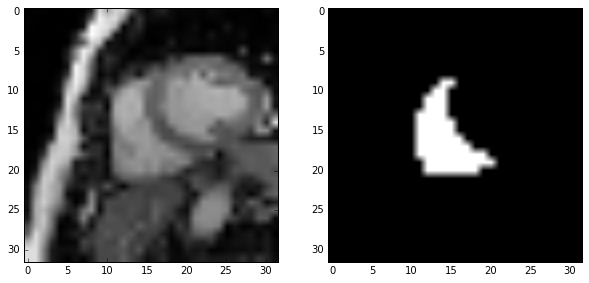

In [12]:
plt.figure(figsize=(10,10))
n1=np.random.randint(X_train.shape[0])
plt.subplot(121)
plt.imshow(X_train[n1,0],cmap='Greys_r')
plt.subplot(122)
plt.imshow(Y_train[n1,0],cmap='Greys_r')
plt.show()

## Generative Mode

In [5]:
# learning rate
lr = 0.0002
# optimizer
adam=Adam(lr=lr, beta_1=0.5 )

print('Generator Model')
a=8 
generator = Sequential()
generator.add(Dense( input_dim=100, output_dim=(128*a*a), init=initNormal))
generator.add(Activation('relu'))
generator.add(Reshape((128, a, a)))	
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(64, 5, 5, border_mode='same'))
generator.add(Activation('relu'))		
generator.add(UpSampling2D(size=(2, 2)))
generator.add(Convolution2D(2, 5, 5, border_mode='same'))
generator.add(Activation('tanh'))
generator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
generator.summary()


Generator Model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 8192)          827392      dense_input_1[0][0]              
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 8192)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
reshape_1 (Reshape)              (None, 128, 8, 8)     0           activation_1[0][0]               
____________________________________________________________________________________________________
upsampling2d_1 (UpSampling2D)    (None, 128, 16, 16)   0           reshape_1[0][0]                  
___________________________________________________________________________

## Discriminitive Model

In [9]:
print('Discriminator Model')
n,c,h,w=X_train.shape
discriminator = Sequential()
discriminator.add(Convolution2D(64, 5, 5, border_mode='same', subsample=(2,2), 
                                input_shape=(c,h,w), init=initNormal))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Convolution2D(128, 5, 5, border_mode='same', subsample=(2,2)))
discriminator.add(LeakyReLU(0.2))
discriminator.add(Flatten())
discriminator.add(Dense(1))
discriminator.add(Activation('sigmoid'))
discriminator.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
discriminator.summary()

Discriminator Model
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
convolution2d_1 (Convolution2D)  (None, 64, 16, 16)    3264        convolution2d_input_1[0][0]      
____________________________________________________________________________________________________
leakyrelu_1 (LeakyReLU)          (None, 64, 16, 16)    0           convolution2d_1[0][0]            
____________________________________________________________________________________________________
convolution2d_2 (Convolution2D)  (None, 128, 8, 8)     204928      leakyrelu_1[0][0]                
____________________________________________________________________________________________________
leakyrelu_2 (LeakyReLU)          (None, 128, 8, 8)     0           convolution2d_2[0][0]            
_______________________________________________________________________

## stack Generator-Discriminator

In [7]:
# Freeze weights in the discriminator for stacked training
make_trainable(discriminator, False)

# Build stacked GAN model
gan_input = Input(shape=[100])
H = generator(gan_input)
gan_V = discriminator(H)
GAN = Model(gan_input, gan_V)
GAN.compile(loss='binary_crossentropy', optimizer=adam)
GAN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 100)           0                                            
____________________________________________________________________________________________________
sequential_1 (Sequential)        (None, 2, 32, 32)     1035458     input_1[0][0]                    
____________________________________________________________________________________________________
sequential_2 (Sequential)        (None, 1)             0           sequential_1[1][0]               
Total params: 1035458
____________________________________________________________________________________________________


## Generate fake images/masks

In [8]:
print 'wait ...'

noise_gen = np.random.uniform(-1,1,size=[n,100])
get_stats(noise_gen)
generated_images = generator.predict(noise_gen)
get_stats(generated_images)
print 'completed!'

wait ...
array shape: (134, 100)
min: -0.999978400675  max: 0.999973411084  mean: -0.00430918568307  std: 0.575961569306
--------------------------------------------------
array shape: (134, 2, 32, 32)
min: -0.264226  max: 0.342298  mean: 0.0401333  std: 0.0665864
--------------------------------------------------
completed!


## pre-train Discriminator

In [9]:
# Pre-train the discriminator network ...
print 'wait ...'
get_stats(X_train)
get_stats(generated_images)
X = np.concatenate((X_train, generated_images))

n = X_train.shape[0]
y = np.zeros([2*n,1])
y[:n,0] = 1 #np.random.rand(n)/2+.7
#y[n:,0] = 1

make_trainable(discriminator,True)
discriminator.fit(X,y, nb_epoch=10, batch_size=8)
y_hat = discriminator.predict(X)
print 'completed!'

wait ...
array shape: (134, 2, 32, 32)
min: -1.0  max: 1.0  mean: -0.358919  std: 0.489723
--------------------------------------------------
array shape: (134, 2, 32, 32)
min: -0.264226  max: 0.342298  mean: 0.0401333  std: 0.0665864
--------------------------------------------------
Epoch 1/10
268/268 [==============================] - 0s - loss: 0.2865 - acc: 0.9664     
Epoch 2/10
268/268 [==============================] - 0s - loss: 0.0051 - acc: 1.0000     
Epoch 3/10
268/268 [==============================] - 0s - loss: 0.0012 - acc: 1.0000     
Epoch 4/10
268/268 [==============================] - 0s - loss: 5.8358e-04 - acc: 1.0000     
Epoch 5/10
268/268 [==============================] - 0s - loss: 3.4634e-04 - acc: 1.0000     
Epoch 6/10
268/268 [==============================] - 0s - loss: 2.3252e-04 - acc: 1.0000     
Epoch 7/10
268/268 [==============================] - 0s - loss: 1.6804e-04 - acc: 1.0000     
Epoch 8/10
268/268 [==============================] - 0s - lo

## Evaluate Discriminator

In [10]:
print 'wait ...'
y_hat_idx = np.argmax(y_hat,axis=1)
y_idx = np.argmax(y,axis=1)
diff = y_idx-y_hat_idx
n_tot = y.shape[0]
n_rig = (diff==0).sum()
acc = n_rig*100.0/n_tot-1
print "Accuracy: %0.02f pct (%d of %d) right"%(acc, n_rig, n_tot)

wait ...
Accuracy: 99.00 pct (268 of 268) right


## train GAN

In [11]:
# set up loss storage vector
losses = {"d":[], "g":[]}

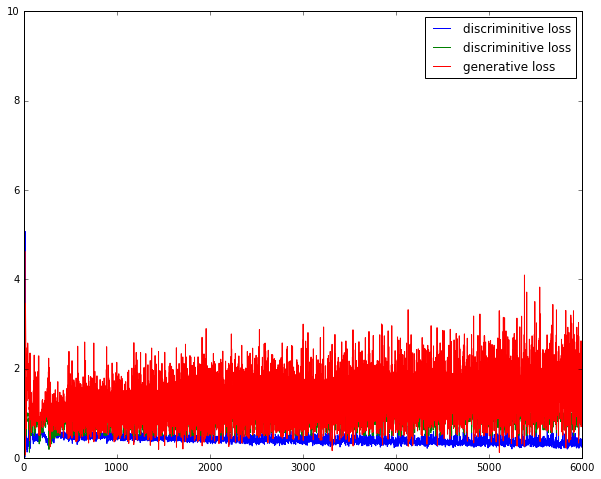

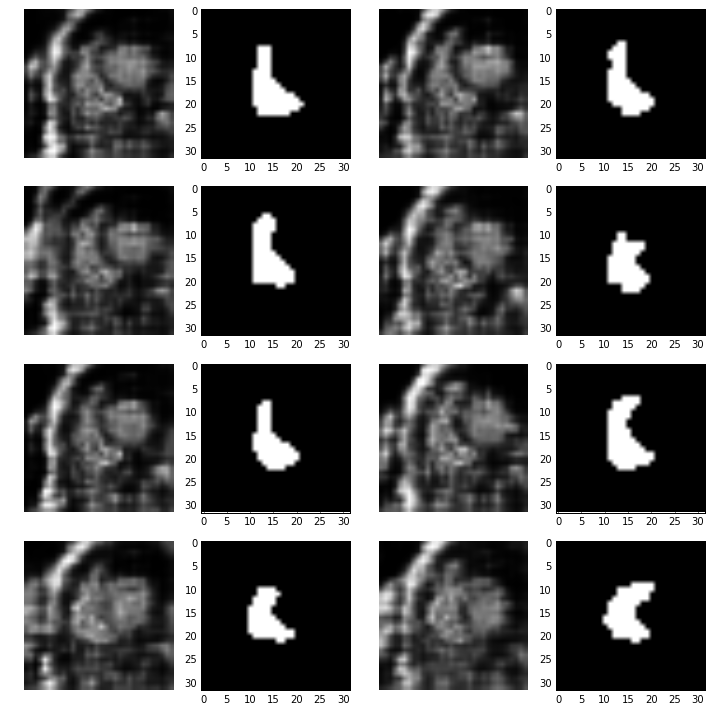

100%|██████████| 6000/6000 [02:02<00:00, 49.06it/s]


In [12]:
train_for_n(nb_epoch=6000, plt_frq=500,BATCH_SIZE=8)

## save weights

In [26]:
weightfolder='./weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2gen_weights=weightfolder+"/gen_weights.hdf5"
path2dis_weights=weightfolder+"/dis_weights.hdf5"
generator.save_weights(path2gen_weights)
discriminator.save_weights(path2dis_weights)
print 'weights saved'

weights saved


## continue training

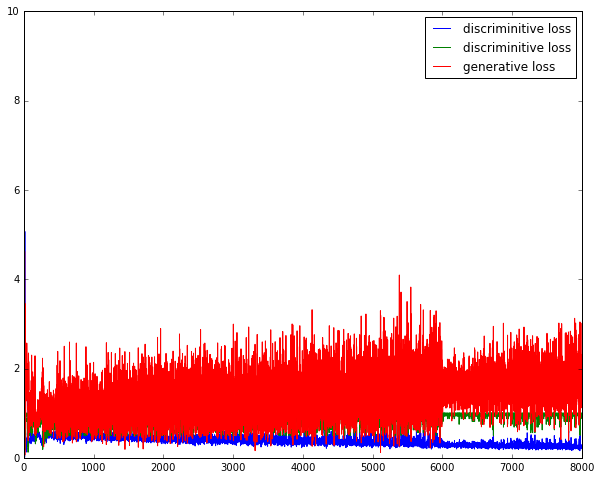

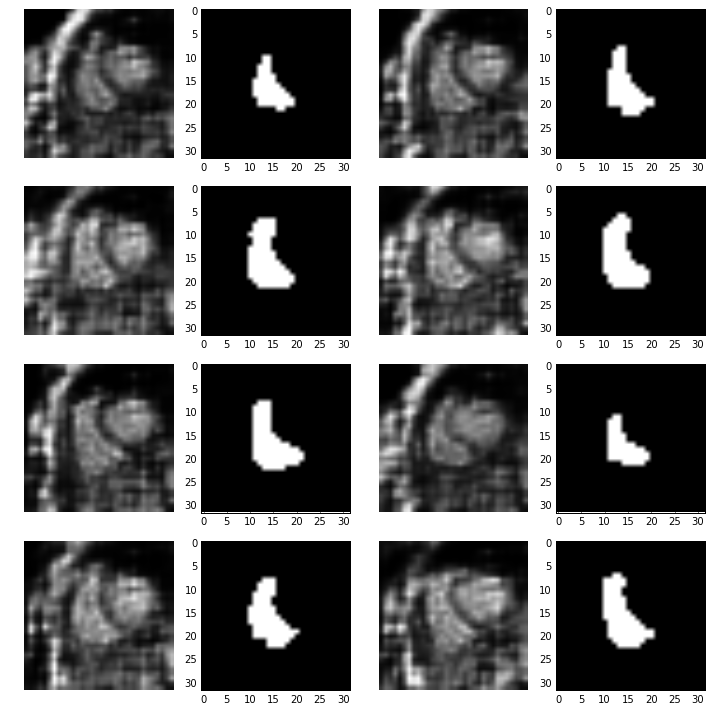

100%|██████████| 2000/2000 [00:41<00:00, 48.29it/s]


In [14]:
adam.lr.set_value(1e-5)
adam.lr.set_value(1e-4)
train_for_n(nb_epoch=2000, plt_frq=400,BATCH_SIZE=8)

## save weights

In [15]:
weightfolder='./weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2gen_weights=weightfolder+"/gen_weights.hdf5"
path2dis_weights=weightfolder+"/dis_weights.hdf5"
generator.save_weights(path2gen_weights)
discriminator.save_weights(path2dis_weights)
print 'weights saved.'

## continue training

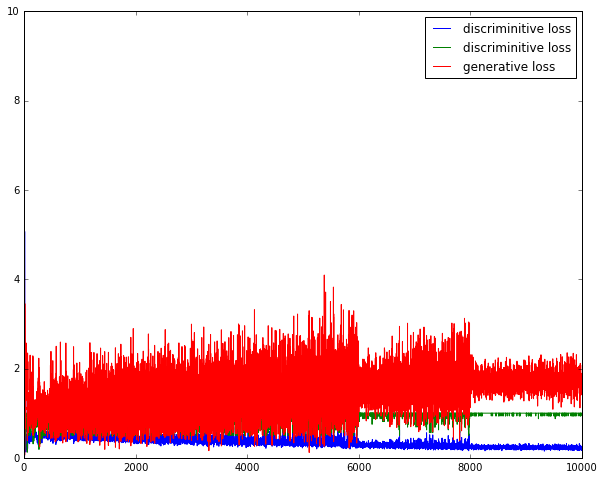

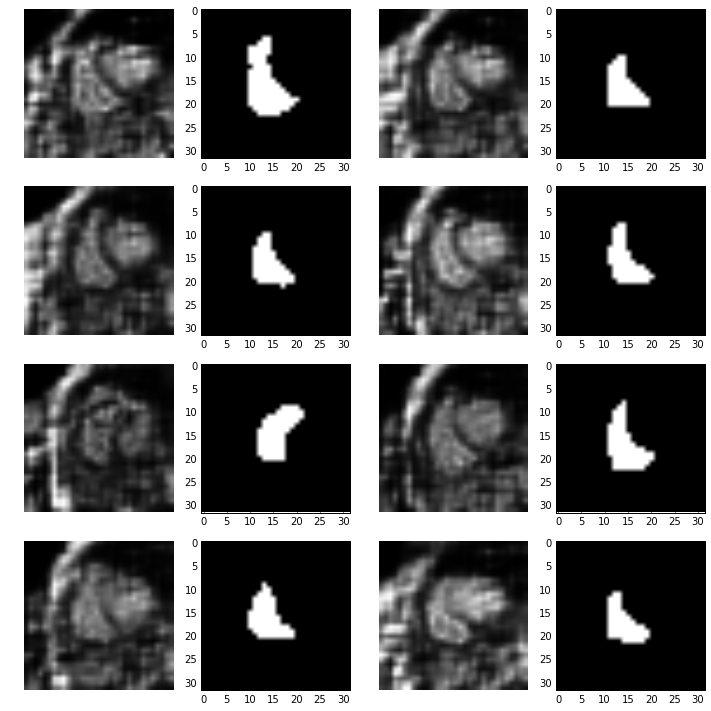

100%|██████████| 2000/2000 [00:43<00:00, 46.42it/s]


In [16]:
adam.lr.set_value(1e-6)
adam.lr.set_value(1e-5)
train_for_n(nb_epoch=2000, plt_frq=400,BATCH_SIZE=8)

## save weights

In [17]:
weightfolder='./weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2gen_weights=weightfolder+"/gen_weights.hdf5"
path2dis_weights=weightfolder+"/dis_weights.hdf5"
generator.save_weights(path2gen_weights)
discriminator.save_weights(path2dis_weights)

## sample generated images with overlays.

array shape: (16, 2, 32, 32)
min: -0.99998  max: 1.0  mean: -0.324758  std: 0.47502
--------------------------------------------------


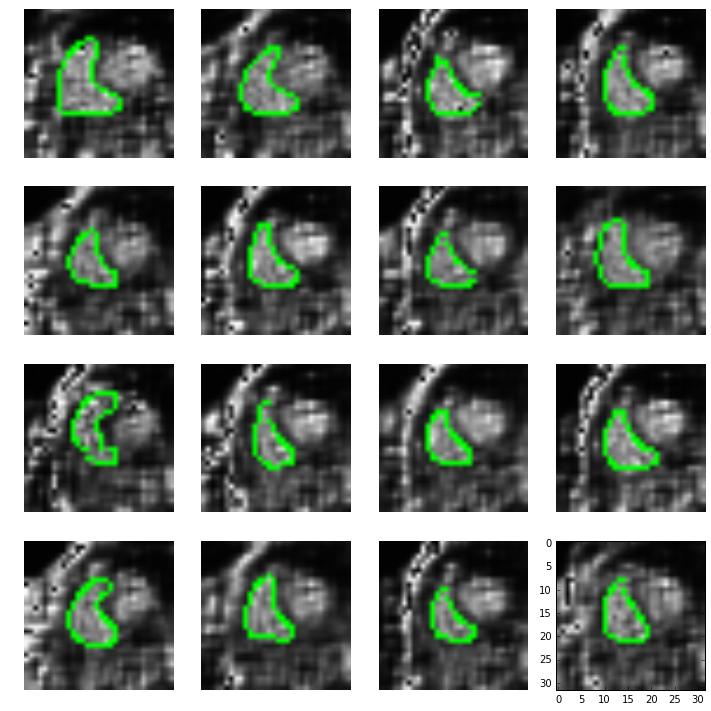

In [48]:
nn=16
noise = np.random.uniform(0,1,size=[nn,100])
generated_images = generator.predict(noise)
get_stats(generated_images)
plt.figure(figsize=(10,10))
for k in range(nn):
    img=generated_images[k,0]
    #img=(img-np.min(img))*255
    mask=generated_images[k,1]>0.5
    img=image_with_mask(img,mask,(-1,1,-1))
    plt.subplot(4,4,k+1)
    plt.imshow(img)
plt.tight_layout()
plt.show()


## sample generated images and masks

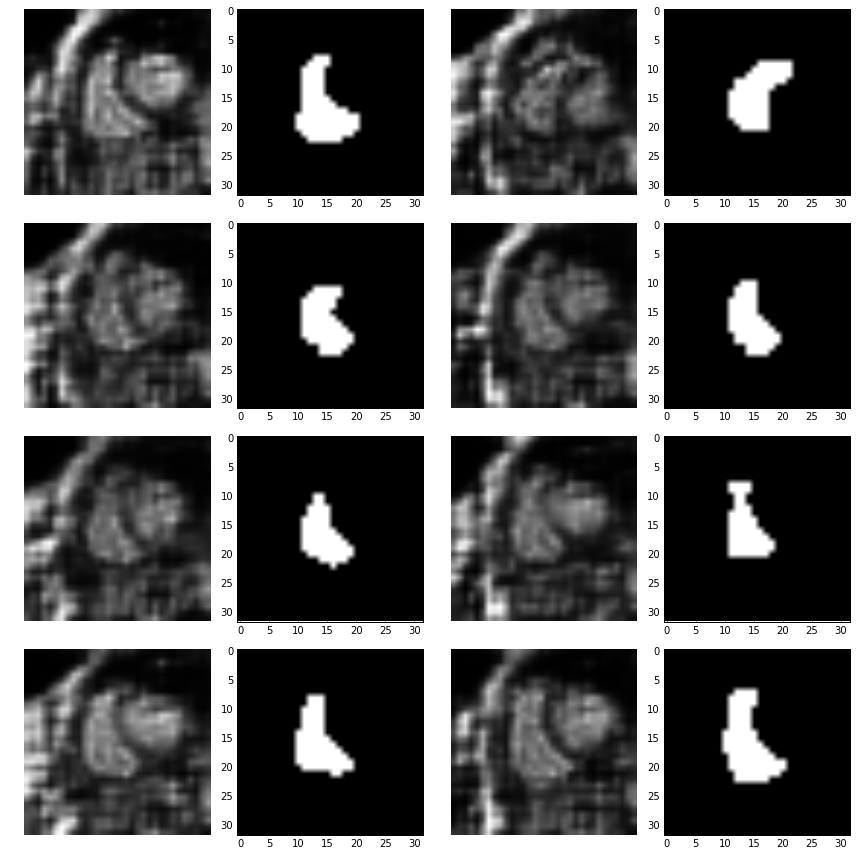

In [46]:
plot_gen(8,(4,4),(12,12))

## real images and masks

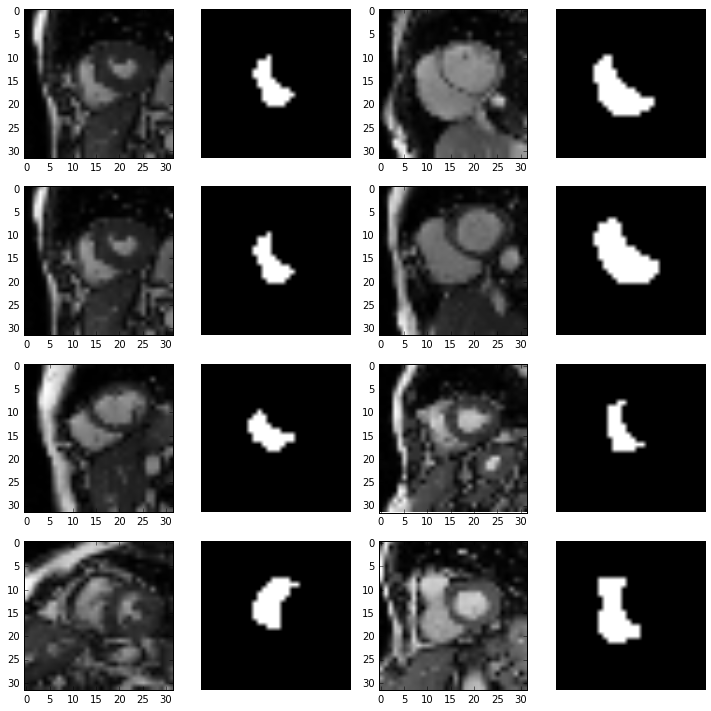

In [23]:
plot_real()

## save weights

In [24]:
experiment='rv32by32'
# checkpoint
weightfolder='./weights/'+experiment
if  not os.path.exists(weightfolder):
    os.makedirs(weightfolder)
    print 'weights folder created'

# path to weights
path2gen_weights=weightfolder+"/gen_weights.hdf5"
path2dis_weights=weightfolder+"/dis_weights.hdf5"
generator.save_weights(path2gen_weights)
discriminator.save_weights(path2dis_weights)

### Inspirations from the following sources 

* [DCGAN](https://github.com/rajathkumarmp/DCGAN)
* [How to Train a GAN?](https://github.com/soumith/ganhacks)
* [KERAS-DCGAN](https://github.com/jacobgil/keras-dcgan)
* [Keras GAN](https://github.com/mravendi/KerasGAN)
* [Keras-GAN](https://github.com/phreeza/keras-GAN)